In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 


In [2]:

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.release_transitions import ReleasedTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml

pd.options.display.max_rows = 200

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1728: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 564 results
transitions_data returned 13 results
total_population_data returned 241 results
initialization time:  18.122004985809326
simulation_time:  14.286443710327148
initialization time:  17.76222014427185
simulation_time:  12.31419587135315
initialization time:  16.45581579208374
simulation_time:  12.66929006576538


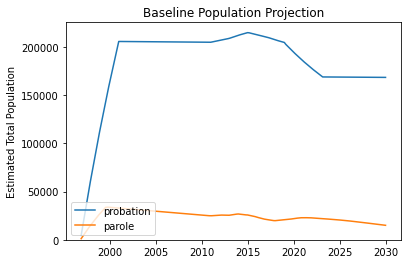

In [9]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/GA/GA_prison_revocations_model_inputs.yaml')
# commented this out once I'm working on the policy but this should be the first thing you run to make sure the simulation is functional
test_sim.simulate_baseline(['probation', 'parole'])

,x


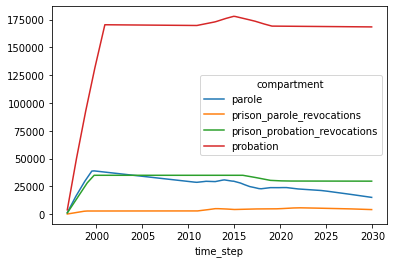

In [4]:
# need to have run baseline for this to work: checking the scale factors are decently close to 1 and population projections look reasonable
t = test_sim.pop_simulations['baseline'].population_projections.groupby(['time_step', 'compartment']).total_population.sum().unstack().drop('release',axis=1)
t.index = test_sim._convert_to_absolute_year(t.index)
t.plot()
test_sim.pop_simulations['baseline'].gen_scale_factors_df()


In [24]:
test_sim.data_dict['outflows_data'][test_sim.data_dict['outflows_data'].outflow_to=='probation']

,Unnamed: 0,compartment,outflow_to,placeholder_axis,compartment_duration,total_population,time_step
133,120,pre-supervision,probation,x,NaN,3855.0,0
134,121,pre-supervision,probation,x,NaN,3855.0,1
135,122,pre-supervision,probation,x,NaN,3855.0,2
136,123,pre-supervision,probation,x,NaN,3855.0,3
137,124,pre-supervision,probation,x,NaN,3855.0,4
138,125,pre-supervision,probation,x,NaN,3855.0,5
139,126,pre-supervision,probation,x,NaN,3855.0,6
140,127,pre-supervision,probation,x,NaN,3855.0,7
141,128,pre-supervision,probation,x,NaN,3855.0,8
142,129,pre-supervision,probation,x,NaN,3855.0,9


In [15]:
# checking the start_year is the most recent year of total-population data
test_sim._convert_to_absolute_year(test_sim.data_dict['total_population_data'].time_step)

577    2010.000000
578    2010.083333
579    2010.166667
580    2010.250000
581    2010.333333
          ...     
812    2019.583333
813    2019.666667
814    2019.750000
815    2019.833333
816    2019.916667
Name: time_step, Length: 240, dtype: float64

In [8]:
#reminding myself what the sub-groups are, in this case there's just one monolithic group
test_sim.pop_simulations['baseline'].sub_group_ids_dict

{'x': {'placeholder_axis': 'x'}}

initialization time:  16.22140884399414
simulation_time:  12.385982275009155
initialization time:  15.505316972732544
simulation_time:  12.223365068435669


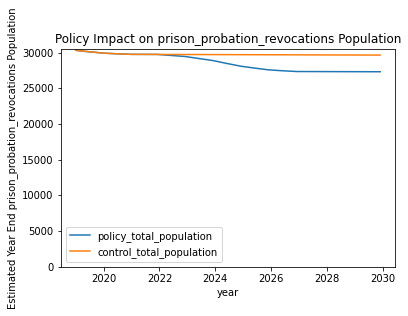

In [6]:
# Policy Option Methods
revocation_outflows = {
    'parole': 'prison_parole_revocations',
    'probation': 'prison_probation_revocations',
}
REVOCATION_REDUCTION = 0.1

def incentivize_completions(reduction, compartment, retroactive=False):
    return partial(CompartmentTransitions.reallocate_outflow, 
                   reallocation_df=pd.DataFrame({
                       'outflow':[revocation_outflows[compartment]],
                       'affected_fraction': [reduction],
                       'new_outflow': [None]
                   }),
                   retroactive=retroactive)


policy_list_non_retroactive = [
    SparkPolicy(policy_fn=incentivize_completions(REVOCATION_REDUCTION, compartment),
                spark_compartment=compartment,
                sub_population={'placeholder_axis': 'x'},
                apply_retroactive=False)
    for compartment in revocation_outflows
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison_probation_revocations')

In [7]:
simulation_tag = 'GA_PO_incentives_10%'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

In [11]:
test_sim.output_data['policy_simulation'].groupby(['year', 'compartment']).policy_total_population.sum().unstack().drop('release',axis=1).plot()


KeyError: 'baseline'

In [42]:
test_sim.output_data['policy_simulation'].groupby(['year', 'compartment']).policy_total_population.sum().unstack()['probation'].iloc[:50]

year
2019.000000    189254.753397
2019.083333    173872.506793
2019.166667    159383.131227
2019.250000    144893.755661
2019.333333    130404.380095
2019.416667    115915.004529
2019.500000    101425.628963
2019.583333     86936.253397
2019.666667     72446.877831
2019.750000     57957.502264
2019.833333     43468.126698
2019.916667     28978.751132
2020.000000     16412.375566
2020.083333      3846.000000
2020.166667      5769.000000
2020.250000      7692.000000
2020.333333      9615.000000
2020.416667     11538.000000
2020.500000     13461.000000
2020.583333     15384.000000
2020.666667     17307.000000
2020.750000     19230.000000
2020.833333     21153.000000
2020.916667     23076.000000
2021.000000     24851.076917
2021.083333     26626.153834
2021.166667     28401.230751
2021.250000     30176.307669
2021.333333     31951.384586
2021.416667     33726.461503
2021.500000     35501.538420
2021.583333     37276.615337
2021.666667     39051.692254
2021.750000     40826.769172
2021.8333

In [26]:
test_sim.gen_arima_output_df()

actuals pred pred_max  \
simulation_group compartment     outflow_to time_step                          
x                pre-supervision parole     0            876.0  NaN      NaN   
                                            1            876.0  NaN      NaN   
                                            2            876.0  NaN      NaN   
                                            3            876.0  NaN      NaN   
                                            4            876.0  NaN      NaN   
                                            5            876.0  NaN      NaN   
                                            6            876.0  NaN      NaN   
                                            7            876.0  NaN      NaN   
                                            8            876.0  NaN      NaN   
                                            9            876.0  NaN      NaN   
                                            10           876.0  NaN      NaN   
                                            11           876.0  NaN      NaN   
                                            12           912.0  NaN      NaN   
                                            13           912.0  NaN      NaN   
                                            14           912.0  NaN      NaN   
                                            15           912.0  NaN      NaN   
                                            16           912.0  NaN      NaN   
                                            17           912.0  NaN      NaN   
                                            18           912.0  NaN      NaN   
                                            19           912.0  NaN      NaN   
                                            20           912.0  NaN      NaN   
                                            21           912.0  NaN      NaN   
                                            22           912.0  NaN      NaN   
                                            23           912.0  NaN      NaN   
                                            24           747.0  NaN      NaN   
                                            25           747.0  NaN      NaN   
                                            26           747.0  NaN      NaN   
                                            27           747.0  NaN      NaN   
                                            28           747.0  NaN      NaN   
                                            29           747.0  NaN      NaN   
                                            30           747.0  NaN      NaN   
                                            31           747.0  NaN      NaN   
                                            32           747.0  NaN      NaN   
                                            33           747.0  NaN      NaN   
                                            34           747.0  NaN      NaN   
                                            35           747.0  NaN      NaN   
                                            36           902.0  NaN      NaN   
                                            37           902.0  NaN      NaN   
                                            38           902.0  NaN      NaN   
                                            39           902.0  NaN      NaN   
                                            40           902.0  NaN      NaN   
                                            41           902.0  NaN      NaN   
                                            42           902.0  NaN      NaN   
                                            43           902.0  NaN      NaN   
                                            44           902.0  NaN      NaN   
                                            45           902.0  NaN      NaN   
                                            46           902.0  NaN      NaN   
                                            47           902.0  NaN      NaN   
                                            48         

In [64]:
test_data = test_sim.data_dict['outflows_data'][(test_sim.data_dict['outflows_data'].outflow_to == 'probation')
                                               & (test_sim.data_dict['outflows_data'].time_step%12 == 0)]
print(test_data)
test_data = test_data.groupby(['outflow_to', 'time_step']).sum().unstack()
test_data

     Unnamed: 0      compartment outflow_to placeholder_axis  \
133         120  pre-supervision  probation                x   
145         132  pre-supervision  probation                x   
157         144  pre-supervision  probation                x   
169         156  pre-supervision  probation                x   
181         168  pre-supervision  probation                x   
193         180  pre-supervision  probation                x   

     compartment_duration  total_population  time_step  
133                   NaN            3855.0          0  
145                   NaN            4000.0         12  
157                   NaN            4000.0         24  
169                   NaN            4104.0         36  
181                   NaN            4083.0         48  
193                   NaN            3846.0         60  


Unnamed: 0                          compartment_duration            \
time_step          0    12   24   36   48   60                   0    12   24   
outflow_to                                                                      
probation         120  132  144  156  168  180                  0.0  0.0  0.0   

                          total_population                                  \
time_step    36   48   60               0       12      24      36      48   
outflow_to                                                                   
probation   0.0  0.0  0.0           3855.0  4000.0  4000.0  4104.0  4083.0   

                    
time_step       60  
outflow_to          
probation   3846.0

In [63]:
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
test_shell = ShellCompartment(test_data, 60, 80, 'test', [], False)
test_shell.gen_arima_output_df()

ValueError: All objects passed were None